In [4]:
# prototype rebuilt scoring method
#   test out sample - e.g. the journals J. Neurophysiol. vs J. Urol.

# scibert vs vanilla bert vs word2vec 

journals = ['J. Neurophysiol.', 'Neuroimage']  # journals = ['Brain Res.', 'J. Virol.']
embedding_conditions = ['bert_mean_embedding',
                      'scibert_mean_embedding']  # todo w2v, CLS position, etc
compare_embeddings = {}


In [1]:
# compare test mysql embedding db's

# check journals and try overlap analysis

import numpy as np
import csv
import os
import time
import json
import mysql.connector as mysql
import sqlalchemy
import pandas as pd


from sklearn.decomposition import PCA
import umap

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm  # for kdemultivariate 
import math
import random

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
'''

from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import Row, StructType, StructField, IntegerType, StringType, ByteType, BinaryType


SUBMIT_ARGS = "--driver-class-path file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar --jars file:///home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar pyspark-shell"
os.environ["PYSPARK_SUBMIT_ARGS"] = SUBMIT_ARGS

url = "jdbc:mysql://localhost:3306/{}?useUnicode=true&useJDBCCompliantTimezoneShift=true&useLegacyDatetimeCode=false&serverTimezone=America/Chicago".format(db_name)  # mysql runs on port 3306

print('initializing spark')
# init spark
conf = SparkConf()
conf = (conf.setMaster('local[*]')
        .set('spark.driver.memory','30G')   # 40
        .set('spark.driver.maxResultSize','10G')
        .set("spark.jars", "/home/brendanchambers/my_resources/mysql-connector-java-8.0.16/mysql-connector-java-8.0.16.jar"))        

sc = SparkContext(conf=conf)
spark = SparkSession(sc)  # don't need this for vanilla RDDs

print(sc._conf.getAll())
'''

client_config = {'unix_socket':'/home/brendanchambers/.sql.sock',
                            'database':'test_pubmed',
                            'use_pure':True}

# load the precomputed embeddings

    todo need to compute these in additional ways

In [9]:
L_per_condition = []

for condition in embedding_conditions:

    compare_embeddings[condition] = {}

    db = mysql.connect(**client_config)

    for i_journal, journal in enumerate(journals):

        start_time = time.time()

        sql = '''SELECT {}.embedding
                FROM {}
                JOIN metadata ON {}.pmid=metadata.pmid
                WHERE metadata.journal = '{}' '''.format(condition, condition, condition, journal)
        print(sql)

        cursor = db.cursor()
        cursor.execute(sql)
        results = cursor.fetchall()
        cursor.close()
                
        compare_embeddings[condition][journal] = [np.frombuffer(e[0],
                                                                dtype="float64") for e in results]
        L_per_condition.append(len(results))
        end_time = time.time()
        print("journals enumerated in {} s".format(end_time - start_time))

    db.close()
    
    # take a quick look    
    print(condition, journal)
    print('first few entries of the embedding vector ok?: ')
    print(compare_embeddings[condition][journal][0][:10])
    print()

SELECT bert_mean_embedding.embedding
                FROM bert_mean_embedding
                JOIN metadata ON bert_mean_embedding.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
journals enumerated in 0.13418960571289062 s
SELECT bert_mean_embedding.embedding
                FROM bert_mean_embedding
                JOIN metadata ON bert_mean_embedding.pmid=metadata.pmid
                WHERE metadata.journal = 'Neuroimage' 
journals enumerated in 0.06836843490600586 s
bert_mean_embedding Neuroimage
first few entries of the embedding vector ok?: 
[-0.31983867 -0.17534736  0.17976169  0.05207332  0.2606954   0.01635771
  0.01559435  0.10239762  0.05067327 -0.19688281]

SELECT scibert_mean_embedding.embedding
                FROM scibert_mean_embedding
                JOIN metadata ON scibert_mean_embedding.pmid=metadata.pmid
                WHERE metadata.journal = 'J. Neurophysiol.' 
journals enumerated in 0.10931706428527832 s
SELECT scibert_mean_embedd

# dimensionality reduction

## pca, not aligned

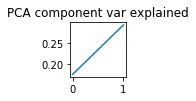

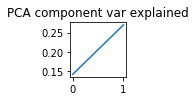

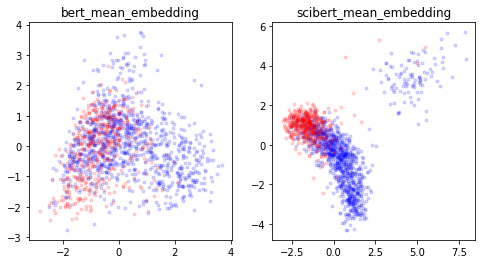

In [18]:
# todo would be nice to align these spaces and then compare

D = 768
D_pca = 2   # most of the variance preserved at around 300 d

pca_models = []

for condition in embedding_conditions:
    
    all_articles = np.zeros((0,D))
    
    for journal in journals:
        thisjournal = compare_embeddings[condition][journal]
        all_articles = np.vstack( (all_articles, thisjournal))
        
    # get pca for this embedding condition
    pca = PCA(n_components=D_pca)
    pc = pca.fit_transform(all_articles)
    pca_models.append(pca)

    plt.figure(figsize=(1,1))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA component var explained')  
    plt.show()

(f, ax) = plt.subplots(1, 2, #  sharex='all', sharey='all',
                      figsize=(8,4))

# first
#   A
samples = compare_embeddings[embedding_conditions[0]][journals[0]]
pc = pca_models[0].transform(samples)
ax[0].scatter(pc[:,0], pc[:,1],
            color=[0, 0, 1, 0.15],marker='.')
#   B
samples = compare_embeddings[embedding_conditions[0]][journals[1]]
pc = pca_models[0].transform(samples)
ax[0].scatter(pc[:,0], pc[:,1],
            color=[1, 0, 0, 0.15],marker='.')
ax[0].set_title(embedding_conditions[0])

# second

#   A
samples = compare_embeddings[embedding_conditions[1]][journals[0]]
pc = pca_models[1].transform(samples)
ax[1].scatter(pc[:,0], pc[:,1],
            color=[0, 0, 1, 0.15],marker='.')

#   B
samples = compare_embeddings[embedding_conditions[1]][journals[1]]
pc = pca_models[1].transform(samples)
ax[1].scatter(pc[:,0], pc[:,1],
            color=[1, 0, 0, 0.15],marker='.')



ax[1].set_title(embedding_conditions[1])

#plt.savefig('J Neurophysiol vs Neuroimaging.png')
#plt.savefig('J Neurophysiol vs Neuroimaging.svg')

# umap, not aligned

Text(0.5, 1.0, 'scibert_mean_embedding')

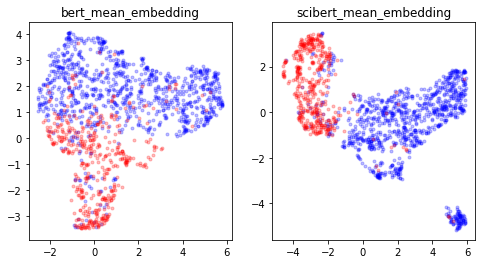

In [11]:
# todo would be nice to align these spaces and then compare

D = 768
D_umap = 2   # most of the variance preserved at around 300 d



umap_models = []

for condition in embedding_conditions:
    
    all_articles = np.zeros((0,D))
    
    for journal in journals:
        thisjournal = compare_embeddings[condition][journal]
        all_articles = np.vstack( (all_articles, thisjournal))
        
    # get pca for this embedding condition
    
    reducer = umap.UMAP()
    um = reducer.fit_transform(all_articles)
    umap_models.append(um)
    
(f, ax) = plt.subplots(1, 2, #  sharex='all', sharey='all',
                      figsize=(8,4))

# first
um = umap_models[0]
#   A
ax[0].scatter(um[:L_per_condition[0],0], um[:L_per_condition[0],1],
            color=[0, 0, 1, 0.25],marker='.')
#   B
ax[0].scatter(um[L_per_condition[0]:,0], um[L_per_condition[0]:,1],
            color=[1, 0, 0, 0.25],marker='.')
ax[0].set_title(embedding_conditions[0])

# second
um = umap_models[1]
#   A
ax[1].scatter(um[:L_per_condition[0],0], um[:L_per_condition[0],1],
            color=[0, 0, 1, 0.25],marker='.')
#   B
ax[1].scatter(um[L_per_condition[0]:,0], um[L_per_condition[0]:,1],
            color=[1, 0, 0, 0.25],marker='.')
ax[1].set_title(embedding_conditions[1])

#plt.savefig('J Neurophysiol vs Neuroimaging_umap.png')
#plt.savefig('J Neurophysiol vs Neuroimaging_umap.svg')

# density estimation and distance measurement

## measure cosine similarity

In [92]:
# helper function

def cos_sim_helper(d_embeddings, title_text='cosine similarities by class'):
    
    ## partition samples in embedding dictionary, for cross-validation 
    #condition = embedding_conditions[0]
    d_partition = {}
    N_partitions = 2  # currently not supporting other choices of N_partitions

    for journal in journals:
        d_partition[journal] = []
        this_journal = d_embeddings[journal].copy()

        L_partition = int(math.ceil((1.0/N_partitions)*len(this_journal)))
        random.shuffle(this_journal)  # shuffle in place

        curPosition = 0
        for partition in range(N_partitions):
            partition_samples = this_journal[curPosition:(curPosition+L_partition)]
            curPosition = L_partition
            d_partition[journal].append(partition_samples)
        

    ### measure cosine similarity within and between samples
    cos_sim_xvalid = {}

    my_colors = [[[0,0.5, 0.5],[0.75, 0.25, 0.5]],
                 [[0.75, 0.5, 0.5], [0, 0.75, 0.25]]]

    plt.figure()

    for i_src, src_journal in enumerate(journals):
        src_samples = d_partition[src_journal][0]

        for i_tgt, tgt_journal in enumerate(journals):
            tgt_samples = d_partition[tgt_journal][1]

            R = cosine_similarity(src_samples, tgt_samples)
            cos_sim_xvalid[(src_journal, tgt_journal)] = R


            plt.hist(R.flatten(),
                     density=True,
                     histtype='step',
                     bins=100,
                     color=my_colors[i_src][i_tgt],
                     alpha=0.5,
                     linewidth=2)
            
            plt.xlabel('cosine similarity')
            plt.ylabel('density')
            plt.title(title_text)
            
    return cos_sim_xvalid

## no dimensionality reduction

(994, 768)


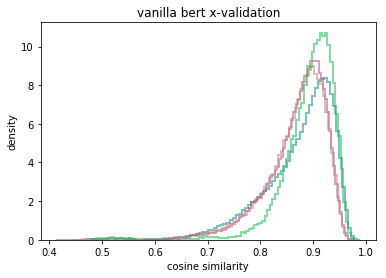

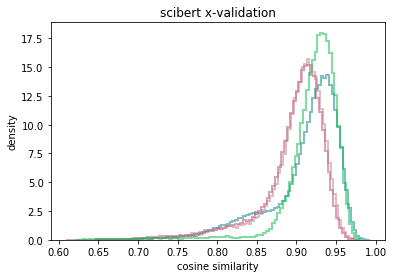

In [108]:
condition = embedding_conditions[0]
xvalid = cos_sim_helper(compare_embeddings[condition],
                        title_text='vanilla bert x-validation')

condition = embedding_conditions[1]
xvalid = cos_sim_helper(compare_embeddings[condition],
                        title_text='scibert x-validation')

### pca

In [105]:
# helper function (calls cosine similarity xvalidation)

def pca_for_xvalid(D_pca, condition):
    
    D = 768
    all_articles = np.zeros((0,D))

    for journal in journals:
        thisjournal = compare_embeddings[condition][journal]
        all_articles = np.vstack((all_articles, thisjournal))

    # get pca for this embedding condition
    pca = PCA(n_components=D_pca)
    pc = pca.fit_transform(all_articles)

    plt.figure(figsize=(1,1))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA component var explained')  
    plt.show()

    embeddings_dictionary = {}
    for journal in journals:
        samples = compare_embeddings[condition][journal]
        embeddings_dictionary[journal] = pca.transform(samples)
        print(np.shape(embeddings_dictionary[journal]))
    
    
    return embeddings_dictionary




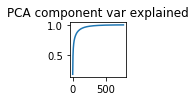

(994, 768)
(454, 768)


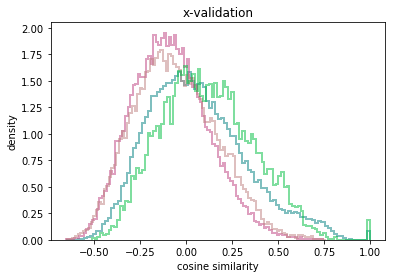

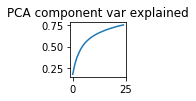

(994, 25)
(454, 25)


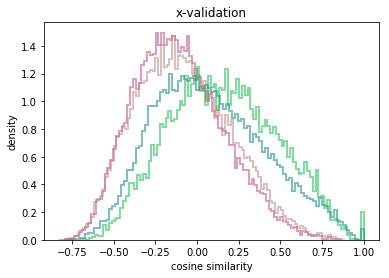

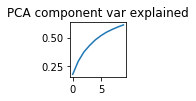

(994, 10)
(454, 10)


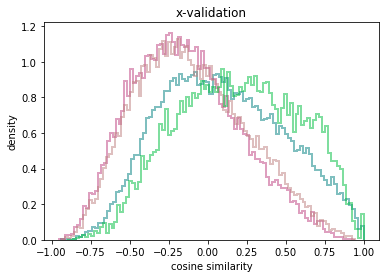

In [130]:
condition = embedding_conditions[0]

D_pca = 768   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_pca = 25   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_pca = 10   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

#plt.savefig('pca bert xvalidation.png')
#plt.savefig('pca bert xvalidation.svg')

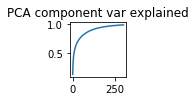

(994, 300)
(454, 300)


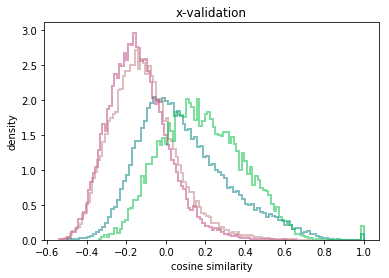

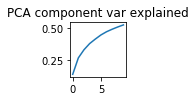

(994, 10)
(454, 10)


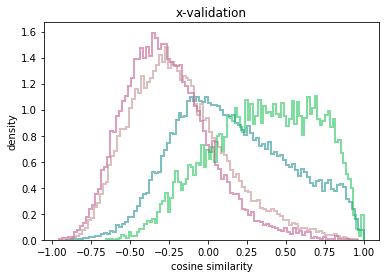

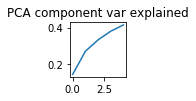

(994, 5)
(454, 5)


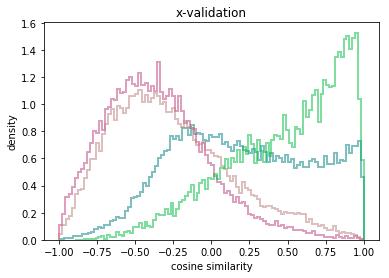

In [131]:
condition = embedding_conditions[1]

D_pca = 300   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_pca = 10   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_pca = 5   # most of the variance preserved at around 300 d
embeddings_dictionary = pca_for_xvalid(D_pca, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

#plt.savefig('pca scibert xvalidation.png')
#plt.savefig('pca scibert xvalidation.svg')

### umap

In [132]:
# helper function (calls cosine similarity xvalidation)

def umap_for_xvalid(D_umap, condition):
    
    D = 768
    all_articles = np.zeros((0,D))

    for journal in journals:
        thisjournal = compare_embeddings[condition][journal]
        all_articles = np.vstack((all_articles, thisjournal))

    # get pca for this embedding condition
    reducer = umap.UMAP(n_components=D_umap)
    um = reducer.fit_transform(all_articles)    

    embeddings_dictionary = {}
    cur = 0
    for i_journal,journal in enumerate(journals):
        samples = compare_embeddings[condition][journal]
        embeddings_dictionary[journal] = um[cur:(cur+L_per_condition[i_journal])]
        cur = L_per_condition[i_journal]
        print(np.shape(embeddings_dictionary[journal]))
    
    
    return embeddings_dictionary

(994, 768)
(454, 768)
(994, 25)
(454, 25)
(994, 10)
(454, 10)


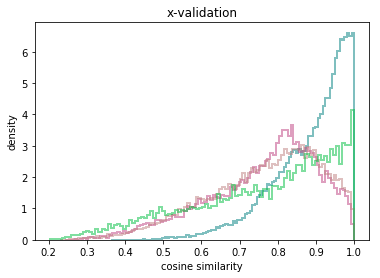

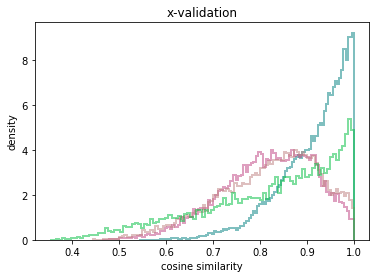

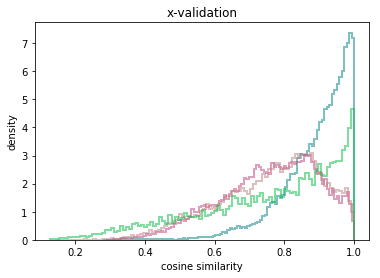

In [134]:
condition = embedding_conditions[0]

D_umap = 768   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_umap = 25   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_umap = 10   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

#plt.savefig('umap bert xvalidation.png')
#plt.savefig('umap bert xvalidation.svg')

(994, 768)
(454, 768)
(994, 25)
(454, 25)
(994, 10)
(454, 10)


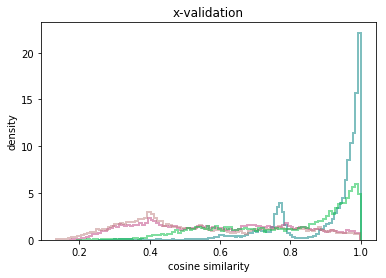

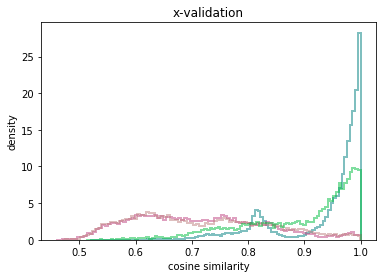

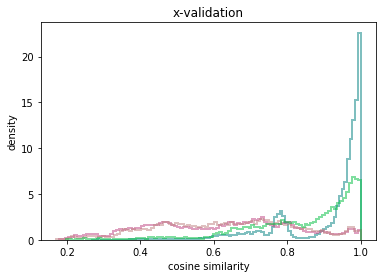

In [133]:
condition = embedding_conditions[1]

D_umap = 768   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_umap = 25   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

D_umap = 10   # most of the variance preserved at around 300 d
embeddings_dictionary = umap_for_xvalid(D_umap, condition)
xvalid = cos_sim_helper(embeddings_dictionary,
                        title_text='x-validation')

#plt.savefig('umap scibert xvalidation.png')
#plt.savefig('umap scibert xvalidation.svg')

In [129]:
#plt.savefig('umap scibert xvalidation.png')
#plt.savefig('umap scibert xvalidation.svg')

<Figure size 432x288 with 0 Axes>

In [ ]:
# try wasserstein distance w pca, more than 2D

D = 768
D_pca = 10   # most of the variance preserved at around 300 d
VAR_TYPE = ''
for dim in range(D_pca):
    VAR_TYPE = VAR_TYPE + 'c'  # control param for the density estimator

pca_models = []

for condition in embedding_conditions:
    
    all_articles = np.zeros((0,D))
    
    for journal in journals:
        thisjournal = compare_embeddings[condition][journal]
        all_articles = np.vstack( (all_articles, thisjournal))
        
    # get pca for this embedding condition
    pca = PCA(n_components=D_pca)
    pc = pca.fit_transform(all_articles)
    pca_models.append(pca)

    plt.figure(figsize=(1,1))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA component var explained')  
    plt.show()

(f, ax) = plt.subplots(1, 2, #  sharex='all', sharey='all',
                      figsize=(8,4))

##########################################
# first
#   A
samples = compare_embeddings[embedding_conditions[0]][journals[0]]
pc = pca_models[0].transform(samples)
ax[0].scatter(pc[:,0], pc[:,1],
            color=[0, 0, 1, 0.25],marker='.')

dens_a = sm.nonparametric.KDEMultivariate(pc,
         var_type=VAR_TYPE, bw='normal_reference')   # warning var_type needs to match n_dimensions

mins = np.ndarray.min(pc, axis=0)
maxes = np.ndarray.max(pc, axis=0)
bw_scalar=4
stepsizes = dens_a.bw / bw_scalar
grid_density_a = get_sample_grid(dens_a, mins, maxes, stepsizes)

print(np.shape(grid_density))

# sanity check
plt.figure()
ax = sns.heatmap(np.sum(grid_density_a,2).T)  # x-y projection
ax.invert_yaxis()
plt.title('density projection, A')
plt.show()

##############
#   B
samples = compare_embeddings[embedding_conditions[0]][journals[1]]
pc = pca_models[0].transform(samples)
ax[0].scatter(pc[:,0], pc[:,1],
            color=[1, 0, 0, 0.25],marker='.')
ax[0].set_title(embedding_conditions[0])

dens_b = sm.nonparametric.KDEMultivariate(pc,
         var_type=VAR_TYPE, bw='normal_reference')   # warning var_type needs to match n_dimensions

mins = np.ndarray.min(pc, axis=0)
maxes = np.ndarray.max(pc, axis=0)
bw_scalar=4
stepsizes = dens_b.bw / bw_scalar
grid_density_b = get_sample_grid(dens_b, mins, maxes, stepsizes)

# sanity check
plt.figure()
ax = sns.heatmap(np.sum(grid_density_b,2).T)  # x-y projection
ax.invert_yaxis()
plt.title('density projection, B')
plt.show()

########

# todo, test and fix the code above
#   next: use pyemd to compare the densities






#############################################
# second

#   A
samples = compare_embeddings[embedding_conditions[1]][journals[0]]
pc = pca_models[0].transform(samples)
ax[1].scatter(pc[:,0], pc[:,1],
            color=[0, 0, 1, 0.25],marker='.')

############3

#   B
samples = compare_embeddings[embedding_conditions[1]][journals[1]]
pc = pca_models[1].transform(samples)
ax[1].scatter(pc[:,0], pc[:,1],
            color=[1, 0, 0, 0.25],marker='.')
ax[1].set_title(embedding_conditions[1])



In [ ]:
# compare within vs between 

In [ ]:
# temp, copied from try_citation_density v1

# want to estimate the density (even when the dimensionality is > 2)

# try statsmodel KDEMultivariate or KDEMultivariateConditional

dens_u = sm.nonparametric.KDEMultivariate(umap_compression,
         var_type='ccc', bw='normal_reference')   # warning var_type needs to match n_dimensions

print(dens_u)
test = dens_u.pdf(data_predict=umap_compression)

print(type(test))
print(np.shape(test))

In [ ]:
# (temp, continued)

# build a grid for sampling the kde

mins = np.ndarray.min(umap_compression, axis=0)
maxes = np.ndarray.max(umap_compression, axis=0)
bw_scalar = 4  # define the stepsize relative to the kde bandwidth for each dimension

domains = []
for i_dim in range(np.shape(umap_compression)[1]):
    stepsize = dens_u.bw[i_dim] / bw_scalar
    domain = np.arange(mins[i_dim], maxes[i_dim], stepsize)
    print(np.shape(domain))
    domains.append(domain)
grid_dimensions = [len(x) for x in domains]
    
sample_grids = np.meshgrid(*domains, indexing='ij') # unpack the list
print(np.shape(sample_grids))

positions = np.vstack(list(map(np.ravel, sample_grids))).T  # convert meminxshgrid to list of points
print(np.shape(positions))
print(np.shape(umap_compression))

grid_samples_list = dens_u.pdf(data_predict=positions)  # get kde estimates for sampled oints
print(np.shape(kde_for_plot))

# project to 2D and plot

# try to reshape to reflect true grid positions
grid_samples = np.reshape(grid_samples_list, grid_dimensions)
print(np.shape(grid_samples))

# todo try to figure out the orientation matching

xy_projection = np.sum(grid_samples,2).T  # todo check seaborn kde implementation to verify orientation correctness
print(np.shape(xy_projection))

#plt.figure()  # matplotlib version
#plt.imshow(xy_projection, aspect='equal', origin='lower')

ax = sns.heatmap(xy_projection)  # seaborn version
ax.invert_yaxis()

In [7]:
# (temp, continued)

# encapsulate into a function

def get_sample_grid(kde_, mins, maxes, stepsizes):
    '''
    kde_: trained statsmodel KDEMultivariate object
    returns: ndarray grid of densities over the domain defined by mins, maxes, and stepsizes
    '''
    domains = []
    for i_dim in range(len(mins)):
        domain = np.arange(mins[i_dim], maxes[i_dim], stepsizes[i_dim])
        domains.append(domain)
    grid_dimensions = [len(x) for x in domains]
    
    sample_grids = np.meshgrid(*domains, indexing='ij') # unpack the list of domains to create meshgrid
    positions = np.vstack(list(map(np.ravel, sample_grids))).T  # convert meshgrid to list of points
    samples_list = kde_.pdf(data_predict=positions)  # get kde estimates for sampled points as list
    samples_grid = np.reshape(samples_list, grid_dimensions)  # ndarray reflecting positions

    return samples_grid


In [ ]:
# from pyemd import emd, emd_samples

In [31]:
db.close()

In [ ]:
# todo rotate vanilla via alignment matrix to make the figures